# dQ

## Import Libraries, set constants

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

""" Using climatological Clouds and Windspeed in the
surface heat flux formulas
"""
rhoa = 1.225
cE = 0.00125
L = 2.5e6
eps = 0.97
sigma = 5.67e-8
ps = 1000
es0 = 6.11
delta = 1.0
f2 = 0.05
# 'a' should decrease when deep convection happens above 28 degC
# a = Ts-T0;a[a>28] = 40;a[a<=28] = 80;a = 0.01*a
a = 0.6

mem = "EEEf"

names = {
    "E": "ECMWF",
    "F": "ECMWF-orig",
    "B": "CMIP5-39m",
    "C": "CMIP5",
    "D": "CMIP5-orig",
    "H": "HadGEM2",
    "f": "fixed",
    "e": "fixed78",
    "g": "fixed82",
    "W": "WHOI",
    "M": "MERRA",
    "I": "ISCCP",
}
vars = {0: "ts", 1: "clt", 2: "sfcWind", 3: "rh"}

## basic parameters

In [2]:
T0 = 273.15 # O degC in Kelvin
f1bar = 0.39
Ubar = 5.0
Tsbar = T0 + 25
Cbar = 0.6
wnspmin = 4.0

## Set up flux functions

In [3]:
# Find linearization of Q_LH (latent heating)
const1 = rhoa * cE * L


def f_es(T):
    return es0 * np.exp(17.67 * (T - T0) / (T - T0 + 243.5))


def f_qs(T):
    return 0.622 * f_es(T) / ps


def f_dqsdT(T):
    return f_qs(T) * (17.67 * 243.5) / (T - T0 + 243.5) ** 2


def f_QLH(T, U, rh):
    return const1 * U * f_qs(T) * (1 - rh)


def f_dQLHdT(T, U, rh):
    return const1 * U * f_dqsdT(T) * (1 - rh)

In [7]:
# Find linearization of Q_LW (longwave)
const2 = eps * sigma


def f_Ta(T):
    return T - delta


def f_ebar(T, rh):
    qa = rh * f_qs(T)
    return qa * ps / 0.622


def f_QLW1(T, C, f, rh):
    Ta = f_Ta(T)
    return const2 * (1 - a * C ** 2) * Ta ** 4 * (f - f2 * np.sqrt(f_ebar(T, rh)))


def f_QLW2(T):
    return 4 * eps * sigma * T ** 3 * (T - f_Ta(T))


def f_QLW(T, f, rh):
    return f_QLW1(T, f, rh) + f_QLW2(T)


def f_dQLWdf(T, C):
    """ Stefan-Boltzman law"""
    return const2 * (1 - a * C ** 2) * T ** 4 


def f_dQLWdT(T, C, f, rh):
    ebar = f_ebar(T, rh)
    qs = f_qs(T)
    dqsdT = f_dqsdT(T)
    return const2 * (
        (1 - a * C ** 2)
        * T ** 3
        * (4 * f - f2 * np.sqrt(ebar) * (4 + T * dqsdT / 2 / qs))
        + 12 * T ** 2 * delta
    )

## Run Through / Load Files

In [5]:

files = []

for i, m in enumerate(mem):
    name = names[m]
    var = vars[i]
    file = "DATA/" + var + "-" + name + "-clim60.nc"
    print(name, var, file)
    assert os.path.isfile(file)
    files += [file]

dclim = xr.open_mfdataset(files, decode_times=False)

ECMWF ts DATA/ts-ECMWF-clim60.nc
ECMWF clt DATA/clt-ECMWF-clim60.nc
ECMWF sfcWind DATA/sfcWind-ECMWF-clim60.nc
fixed rh DATA/rh-fixed-clim60.nc


In [ ]:
#plt.figure(figsize=(8,3))
#dp=(dclim.ts - 273.15).plot.contourf(levels=11,cmap="jet",vmin=22,vmax=30,add_colorbar=0)
#plt.title(r'$\bar T_{s,O}$')
#plt.ylabel('latitude');plt.xlabel('longitude')
#cbar = plt.colorbar(dp)
#plt.show()

In [ ]:
#dclim.clt.plot()

## Add things to the xarray object

In [8]:
# set Q'_LW + Q'_LH = 0, solve for Ts' (assuming U'=0)
#       Q'_LW = ALW(Tsbar,Cbar,f1bar)* Tsprime + BLW(Tsbar,Cbar) * f1prime
#       Q'_LH = ALH(Tsbar,Ubar) * Tsprime
Tsb = 1.0 * dclim.ts
tmp = 1.0 * dclim.sfcWind.stack(z=("lon", "lat")).load()
tmp[tmp < wnspmin] = wnspmin
Ub = tmp.unstack("z").T
Cb = dclim.clt / 100.0
rh = dclim.rh / 100.0
f1p = -0.003

ALH0 = f_dQLHdT(Tsb, Ubar, rh)
ALW0 = f_dQLWdT(Tsb, Cbar, f1bar, rh)
BLW0 = f_dQLWdf(Tsb, Cbar)
dTse0 = -BLW0 * f1p / (ALH0 + ALW0)
dclim["dTse0"] = dTse0

ALH1 = f_dQLHdT(Tsb, Ub, rh)
ALW1 = f_dQLWdT(Tsb, Cbar, f1bar, rh)
BLW1 = f_dQLWdf(Tsb, Cbar)
dTse1 = -BLW1 * f1p / (ALH1 + ALW1)
dclim["dTse1"] = dTse1

ALH2 = f_dQLHdT(Tsb, Ubar, rh)
ALW2 = f_dQLWdT(Tsb, Cb, f1bar, rh)
BLW2 = f_dQLWdf(Tsb, Cb)
dTse2 = -BLW2 * f1p / (ALH2 + ALW2)
dclim["dTse2"] = dTse2

ALH = f_dQLHdT(Tsb, Ub, rh)
ALW = f_dQLWdT(Tsb, Cb, f1bar, rh)
BLW = f_dQLWdf(Tsb, Cb)
dTse = -BLW * f1p / (ALH + ALW)

dclim["dTse"] = dTse
dclim["ALH"] = ALH
dclim["ALW"] = ALW
dclim["BLW"] = BLW
dclim["QLW"] = ALW + BLW * f1p / dTse
# dclim.to_netcdf('Q.nc')

## Plot Results

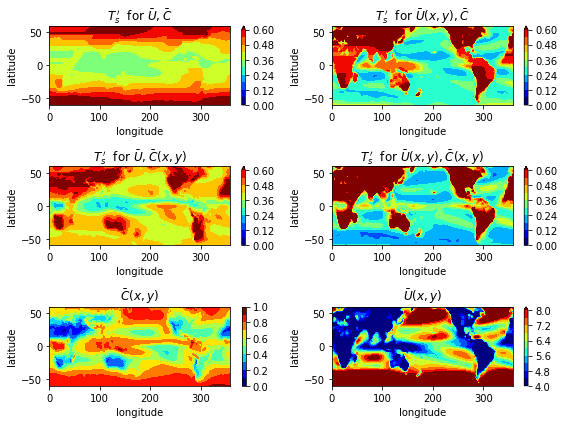

In [9]:
plt.figure(figsize=(8, 6))
plt.subplot(321)
dp = dclim.dTse0.plot.contourf(
    levels=11, cmap="jet", vmin=0.0, vmax=0.6, add_colorbar=0
)
# ,vmin=-2,vmax=2,add_colorbar=0)
plt.title(r"$T^{\,\prime}_s$  for $\bar U,\bar C$")
plt.ylabel("latitude")
plt.xlabel("longitude")
cbar = plt.colorbar(dp)
plt.subplot(322)
dp = dclim.dTse1.plot.contourf(
    levels=11, cmap="jet", vmin=0.0, vmax=0.6, add_colorbar=0
)
# ,vmin=-2,vmax=2,add_colorbar=0)
plt.title(r"$T^{\,\prime}_s$  for $\bar U(x,y), \bar C$")
plt.ylabel("latitude")
plt.xlabel("longitude")
cbar = plt.colorbar(dp)
plt.subplot(323)
dp = dclim.dTse2.plot.contourf(
    levels=11, cmap="jet", vmin=0.0, vmax=0.6, add_colorbar=0
)
# ,vmin=-2,vmax=2,add_colorbar=0)
plt.title(r"$T^{\,\prime}_s$  for $\bar U, \bar C(x,y)$")
plt.ylabel("latitude")
plt.xlabel("longitude")
cbar = plt.colorbar(dp)
plt.subplot(324)
dp = dclim.dTse.plot.contourf(levels=11, cmap="jet", vmin=0.0, vmax=0.6, add_colorbar=0)
# ,vmin=-2,vmax=2,add_colorbar=0)
plt.title(r"$T^{\,\prime}_s$  for $\bar U(x,y), \bar C(x,y)$")
plt.ylabel("latitude")
plt.xlabel("longitude")
cbar = plt.colorbar(dp)
plt.subplot(325)
dp = (dclim.clt / 100).plot.contourf(
    levels=11, cmap="jet", vmin=0.0, vmax=1.0, add_colorbar=0
)
# ,vmin=-2,vmax=2,add_colorbar=0)
plt.title(r"$\bar C(x,y)$")
plt.ylabel("latitude")
plt.xlabel("longitude")
cbar = plt.colorbar(dp)
plt.subplot(326)
dp = Ub.plot.contourf(levels=11, cmap="jet", vmin=4.0, vmax=8.0, add_colorbar=0)
# ,vmin=-2,vmax=2,add_colorbar=0)
plt.title(r"$\bar U(x,y)$")
plt.ylabel("latitude")
plt.xlabel("longitude")
cbar = plt.colorbar(dp)
plt.tight_layout()
plt.savefig("Tsp4.eps", format="eps", dpi=1000)
plt.show()

## Now, save the dQdf and dQdT terms for using in TCOM:

In [10]:
# Now, save the dQdf and dQdT terms for using in TCOM:
dQdT = ALH + ALW
dQdf = BLW

# Define the new Dataset
dQ = xr.Dataset(
    {
        "lon": ("lon", dclim.lon),
        "lat": ("lat", dclim.lat),
        "dQdT": (["lat", "lon"], dQdT),
        "dQdf": (["lat", "lon"], dQdf),
    }
)
dQ.lon.attrs = dclim.lon.attrs
dQ.lat.attrs = dclim.lat.attrs
dQ.dQdT.attrs = [("units", "W/m^2/K")]
dQ.dQdf.attrs = [("units", "W/m^2")]
dQ["ALH"] = ALH
dQ["ALW"] = ALW
dQ["BLW"] = BLW
dQ["dTse"] = dTse
dQ["rh"] = rh
dQ["Ub"] = Ub
dQ["Cb"] = Cb
dQ["Tsb"] = Tsb

In [ ]:
dQ.to_netcdf("dQ.nc")